### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from imblearn.over_sampling import SMOTE
from zipfile import ZipFile

import wrangle

### Certain configs for visualizations

In [2]:
import matplotlib.style as style
style.use('seaborn-colorblind')

/var/folders/h6/xxqcvddd61v8kq3bhvkfyqzw0000gn/T/ipykernel_32248/29349232.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


### Acquire datasets

In [3]:
test, df = wrangle.acquire_fraud('cc_fraud.zip')

In [4]:
test.shape,df.shape

((555719, 23), (1296675, 23))

### Clean and Prep

In [5]:
df = wrangle.prep(df)
test = wrangle.prep(test)

In [6]:
df.head()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,,
2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,28654,3495,"Psychologist, counselling",36.011293,-82.048315,0,30,Tuesday,0,Young_Adult
2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,99160,149,Special educational needs teacher,49.159047,-118.186462,0,40,Tuesday,0,Adult
2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,83252,4154,Nature conservation officer,43.150704,-112.154481,0,56,Tuesday,0,Mid_Age
2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,59632,1939,Patent attorney,47.034331,-112.561071,0,52,Tuesday,0,Early_Mid_Age
2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,24433,99,Dance movement psychotherapist,38.674999,-78.632459,0,32,Tuesday,0,Young_Adult


### Define target ('is_fraud') versus the rest of the features

In [7]:
target,features = wrangle.get_target_and_features(df)
print(target)
print('______')
print(features)

is_fraud
______
['merchant', 'category', 'amt', 'gender', 'zip', 'city_pop', 'job', 'merch_lat', 'merch_long', 'age', 'dayofweek', 'hourofday', 'age_group']


### Split the training data further (into Train and Validate)

In [8]:
x_train,x_validate,y_train,y_validate = wrangle.train_val(df)

In [9]:
x_train.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,
2019-08-12 21:52:06,fraud_Padberg-Rogahn,entertainment,71.76,M,3601,477,Naval architect,43.200583,-73.195777,31,Monday,21,Young_Adult


In [10]:
y_train.sample()

trans_date_trans_time
2020-04-13 18:37:27    0
Name: is_fraud, dtype: int64

### Break the TEST dataset into x and y sets

In [11]:
x_test,y_test = wrangle.test_df_x_y_split(test)

In [12]:
x_test.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,
2020-11-15 13:41:22,fraud_Jerde-Hermann,travel,6.5,F,92637,45303,Sales executive,33.283938,-118.436578,50,Sunday,13,Early_Mid_Age


In [13]:
y_test.sample()

trans_date_trans_time
2020-12-31 18:05:52    0
Name: is_fraud, dtype: int64

# Begin EDA (using the original DF, which includes train and validate data)

In [14]:
# df.isna().sum()
# There are NO nulls

### First of all...CLASS IMBALANCE?

In [15]:
df.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

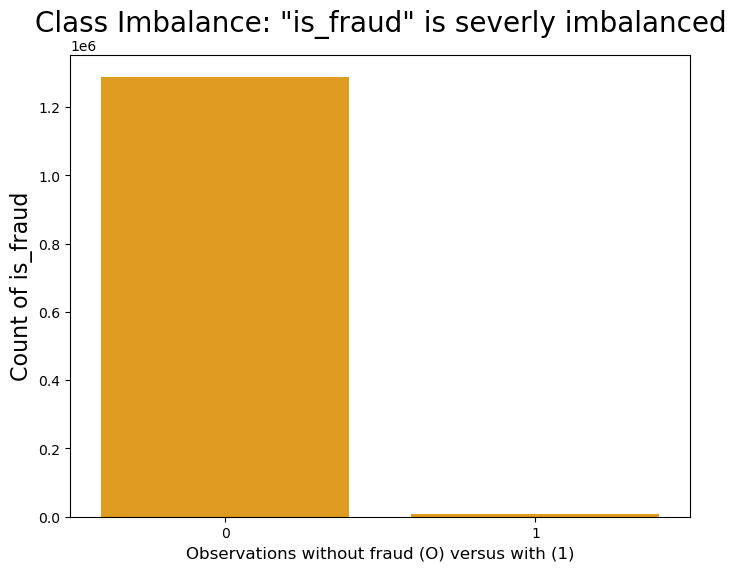

In [16]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(x=df['is_fraud'],color='orange')
ax.set_xlabel(xlabel = 'Observations without fraud (O) versus with (1)', fontsize = 12)
ax.set_ylabel(ylabel = 'Count of is_fraud', fontsize = 16)
ax.set_title(label = 'Class Imbalance: "is_fraud" is severly imbalanced', fontsize = 20)

plt.show()

### Amount?

In [17]:
amount_df = df.copy()
amount_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,,
2020-06-01 14:48:23,"fraud_Romaguera, Cruickshank and Greenholt",shopping_net,4.65,F,29911,1725,Social researcher,31.97856,-80.417485,0,45,Monday,14,Early_Mid_Age


In [18]:
amount_df.amt.min(),amount_df.amt.max()

(1.0, 28948.9)

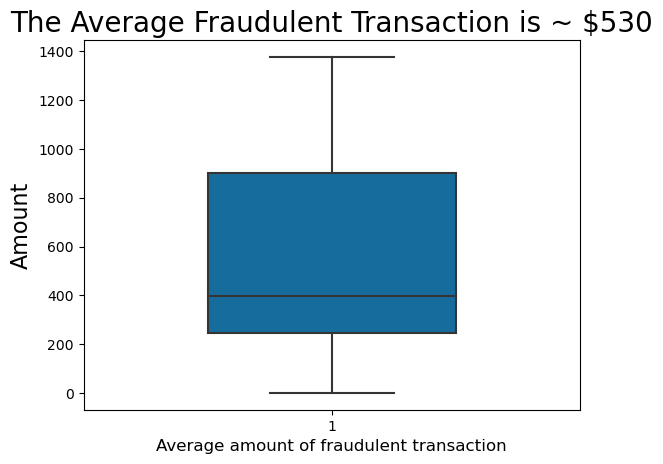

In [19]:
ax = sns.boxplot(data=amount_df[amount_df['is_fraud']==1],y=amount_df[amount_df['is_fraud']==1].amt,x=amount_df[amount_df['is_fraud']==1].is_fraud,width=.5)
ax.set_xlabel(xlabel = 'Average amount of fraudulent transaction', fontsize = 12)
ax.set_ylabel(ylabel = 'Amount', fontsize = 16)
ax.set_title(label = 'The Average Fraudulent Transaction is ~ $530', fontsize = 20)
plt.show()

In [20]:
df[df['is_fraud']==1].amt.min(),df[df['is_fraud']==1].amt.max(),df[df['is_fraud']==1].amt.mean()

(1.06, 1376.04, 531.3200919264589)

In [21]:
np.arange(0,1200,50)

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150])

In [22]:
# df['age_group'] = pd.cut(df['age'],[0,25,35,45,55,65,75,100], labels= ['Youth','Young_Adult','Adult','Early_Mid_Age','Mid_Age','Retirement_Age','Older_Person'],right=False)

amount_df['amt_bin'] = pd.cut(amount_df['amt'],np.arange(0,1200,50), right = False)
amount_df.sample(2)

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin
trans_date_trans_time,,,,,,,,,,,,,,,
2020-04-05 20:26:27,fraud_Deckow-Dare,food_dining,48.99,F,64058,123373,"Engineer, production",39.212698,-94.760683,0,27,Sunday,20,Young_Adult,"[0, 50)"
2020-03-10 13:10:17,fraud_Monahan-Morar,personal_care,3.48,F,25106,642,Building services engineer,39.721017,-82.750481,0,73,Tuesday,13,Retirement_Age,"[0, 50)"


In [23]:
amount_df[amount_df['is_fraud']==1].amt_bin.value_counts()

amt_bin
[0, 50)         1607
[300, 350)       974
[250, 300)       701
[900, 950)       487
[950, 1000)      456
[850, 900)       450
[750, 800)       411
[800, 850)       381
[1000, 1050)     364
[1050, 1100)     282
[700, 750)       252
[350, 400)       186
[1100, 1150)     165
[100, 150)       145
[650, 700)       122
[200, 250)        94
[450, 500)        61
[500, 550)        50
[600, 650)        45
[50, 100)         45
[550, 600)        44
[400, 450)        40
[150, 200)         5
Name: count, dtype: int64

### Could there be a polynomial relationship in the amount bins?

In [78]:
# amount_df['amt_bin_fraud_ratio'] = 
# amount_df[amount_df['is_fraud']==1]['amt_bin']

down_sample = amount_df.sample(10_000)

In [89]:
down_sample.head(1)

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin
trans_date_trans_time,,,,,,,,,,,,,,,
2019-12-15 16:39:28,fraud_Lynch-Wisozk,home,20.31,M,80138,84861,Materials engineer,39.438077,-104.728213,0,87,Sunday,16,Older_Person,"[0, 50)"


In [88]:
# down_sample.amt.groupby([down_sample['amt_bin'],down_sample['is_fraud'],down_sample['amt_bin']]).size().unstack(0)
down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0)

amt_bin,"[0, 50)","[50, 100)","[100, 150)","[150, 200)","[200, 250)","[250, 300)","[300, 350)","[350, 400)","[400, 450)","[450, 500)",...,"[650, 700)","[700, 750)","[750, 800)","[800, 850)","[850, 900)","[900, 950)","[950, 1000)","[1000, 1050)","[1050, 1100)","[1100, 1150)"
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,5160,2974,990,379,175,55,40,21,21,25,...,6,5,4,1,5,1,4,2,3,0
1,13,0,3,0,0,5,9,0,0,1,...,1,1,3,2,3,4,6,4,5,4


In [82]:
bins_fraud_breakdown = down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0)
bins_fraud_sum = down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0).sum()

In [95]:
percentage_df = bins_fraud_breakdown/bins_fraud_sum
percentage_df

amt_bin,"[0, 50)","[50, 100)","[100, 150)","[150, 200)","[200, 250)","[250, 300)","[300, 350)","[350, 400)","[400, 450)","[450, 500)",...,"[650, 700)","[700, 750)","[750, 800)","[800, 850)","[850, 900)","[900, 950)","[950, 1000)","[1000, 1050)","[1050, 1100)","[1100, 1150)"
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,0.997487,1.0,0.996979,1.0,1.0,0.916667,0.816327,1.0,1.0,0.961538,...,0.857143,0.833333,0.571429,0.333333,0.625,0.2,0.4,0.333333,0.375,0.0
1,0.002513,0.0,0.003021,0.0,0.0,0.083333,0.183673,0.0,0.0,0.038462,...,0.142857,0.166667,0.428571,0.666667,0.375,0.8,0.6,0.666667,0.625,1.0


In [97]:
ratio_fraud = percentage_df[percentage_df.index == 1]
ratio_fraud

amt_bin,"[0, 50)","[50, 100)","[100, 150)","[150, 200)","[200, 250)","[250, 300)","[300, 350)","[350, 400)","[400, 450)","[450, 500)",...,"[650, 700)","[700, 750)","[750, 800)","[800, 850)","[850, 900)","[900, 950)","[950, 1000)","[1000, 1050)","[1050, 1100)","[1100, 1150)"
is_fraud,,,,,,,,,,,,,,,,,,,,,
1,0.002513,0.0,0.003021,0.0,0.0,0.083333,0.183673,0.0,0.0,0.038462,...,0.142857,0.166667,0.428571,0.666667,0.375,0.8,0.6,0.666667,0.625,1.0


In [119]:
temp_df = pd.DataFrame(ratio_fraud.unstack(0)).droplevel(1)
temp_df

,0
amt_bin,
"[0, 50)",0.002513
"[50, 100)",0.000000
"[100, 150)",0.003021
"[150, 200)",0.000000
"[200, 250)",0.000000
"[250, 300)",0.083333
"[300, 350)",0.183673
"[350, 400)",0.000000
"[400, 450)",0.000000


In [126]:
fraud_ratio_per_bin_df = amount_df.merge(temp_df,on=['amt_bin'])

In [136]:
fraud_ratio_per_bin_df = fraud_ratio_per_bin_df.rename(columns={0:'perc_fraud_in_bin'})

In [137]:
fraud_ratio_per_bin_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin,perc_fraud_in_bin
1161186,fraud_O'Hara-Wilderman,food_dining,88.32,F,71291,54185,"Radiographer, diagnostic",32.768837,-91.961203,0,27,Monday,13,Young_Adult,"[50, 100)",0.0


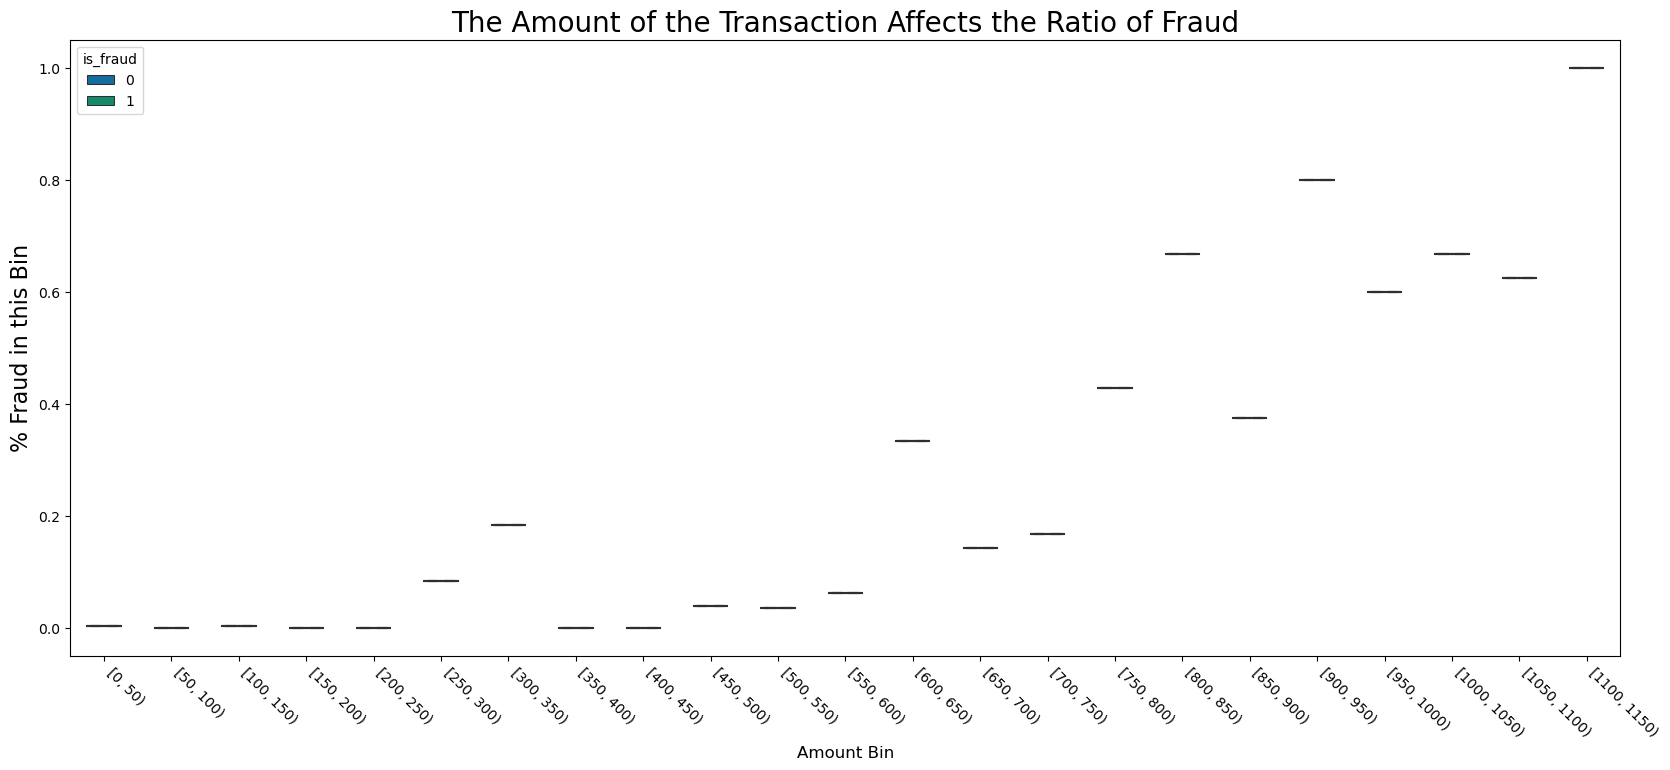

In [141]:
plt.figure(figsize = (20, 8))
ax = sns.boxplot(data=fraud_ratio_per_bin_df,y=fraud_ratio_per_bin_df.perc_fraud_in_bin,x=fraud_ratio_per_bin_df.amt_bin,hue=fraud_ratio_per_bin_df.is_fraud,width=.5)
ax.set_xlabel(xlabel = 'Amount Bin', fontsize = 12)
ax.set_ylabel(ylabel = '% Fraud in this Bin', fontsize = 16)
ax.set_title(label = 'The Amount of the Transaction Affects the Ratio of Fraud', fontsize = 20)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
plt.show()

In [29]:
df.columns

Index(['merchant', 'category', 'amt', 'gender', 'zip', 'city_pop', 'job',
       'merch_lat', 'merch_long', 'is_fraud', 'age', 'dayofweek', 'hourofday',
       'age_group'],
      dtype='object')